### Teste de hipotese

Esse notebook tem por objetivo detectar varios pontos e gerar um descritor otimo que seja resitente a variacoes de transformacoes afins e pequenas transformacoes projetivas, para isso temos:

-- BaseFeatures para extrair informacoes equivariantes (num_channels,dim_first,dim_second,dim_third).

-- SingularPoints lida com escala , e extrai as features consolidadas, em dim_third caracteristicas distintas, orientacao computadas além da lista de pontos.

-- Computa a funcao de perda entre os mapas de orientacao e feature e os pontos que colidiram

In [ ]:
# !git clone -b siamese https://github.com/wagner1986/singular-points.git singular_points
# !pip install kornia e2cnn

# !pwd
# %cd /content/singular_points
# !pwd

In [1]:
import torch
from e2cnn import gspaces
from e2cnn import nn as enn    #the equivariant layer we need to build the model
from torch import nn
import numpy as np

In [2]:
from config import args, device
def custom_config(args):
    args.num_channels = 3
    args.img_size = 128
    args.dim_first = 3
    args.dim_second = 5
    args.dim_third = 8
    args.batch_size = 8
    args.margin_loss = 4.0
    args.border  = 21
    args.nms_size = 5 # normal é 10, alterei so pra avaliar o match
    args.box_size = 31
    args.exported = False
    return args

POINTS_LIMIT = 20
args = custom_config(args)
device

device(type='cuda')

In [3]:
def criar_mascara(dimensao_janela, tamanho_borda):
    
    mascara = torch.zeros((args.batch_size,1, dimensao_janela, dimensao_janela), dtype=torch.uint8)
    mascara[..., tamanho_borda:-tamanho_borda, tamanho_borda:-tamanho_borda] = 1

    return mascara.to(torch.float32)

In [4]:
class MaxPointDetector:
    """
    Class for detecting maximum points in images or tensors.

    Methods:
    - detect_max_points: Applies a maximum point filter on a batch of images.
    - filter_coordinates: Filters coordinates in a tensor based on image and channel indices.
    - Sorts the rows of a matrix based on the last element of each row.
    """

    def detect_max_points(self, images, size=15, threshold=1e-3):
        max_map = F.max_pool2d(images, size, stride=1, padding=(size - 1) // 2)

        max_coords = (max_map > threshold) & (max_map == images)
        max_coords = max_coords.nonzero()
        max_values = max_map[max_coords[:, 0], max_coords[:, 1], max_coords[:, 2], max_coords[:, 3]]

        

        max_coords_values = torch.cat((max_coords, max_values.unsqueeze(1)), dim=1)
        max_coords_values = max_coords_values[:, [0,1,3,2,4]]# trocando x e y de ordem antes de concatenar

        return max_coords_values, max_map.squeeze().numpy()
    
    def sort_tensor_by_columns(self,tensor):
        # Ordena pela última coluna
        sorted_indices = torch.argsort(tensor[:, -1],descending=True)
        tensor_sorted_by_last_column = tensor[sorted_indices]
        return tensor_sorted_by_last_column
    
    def filter_coordinates(self, tensor, image_index, channel_index):
        # Filter the values where the image and channel indices are equal to the provided values
        mask = (tensor[:, 0] == image_index) & (tensor[:, 1] == channel_index)
        filtered_coords = torch.masked_select(tensor[:, 2:], mask.unsqueeze(1)).reshape(-1, 3)
        return filtered_coords


def check_valid_points(points, mask):
    # Check limits of points
    height_mask, width_mask = mask.shape[-2:]
    limits_valid = (points[..., 0].long() >= 0) & (points[..., 0].long() < width_mask) & (points[..., 1].long() >= 0) & (points[..., 1].long() < height_mask)

    # Check if points are within the mask region with value equal to 1
    mask_valid = torch.ones_like(limits_valid)
    if mask is not None:
        mask_valid = mask[..., points[..., 1].long().unsqueeze(-1), points[..., 0].long().unsqueeze(-1)] == 1

    # Combine the checks to get the valid points
    valid_points = points[limits_valid & mask_valid.squeeze()]

    return valid_points

In [5]:
r2_act = gspaces.Rot2dOnR2(N=args.group_size)#N=8 is the number of Groups equivariant
OUT_SHAPE = args.img_size
#This model is base to build the model for singular points detection e orientation estimation
class BaseFeatures(nn.Module):
    #This model extract 8 features from the image
    def __init__(self, args) -> None:
        super().__init__()
        self.pyramid_levels = args.pyramid_levels
        self.scale = args.scale_pyramid
        self.feat_type_in = enn.FieldType(r2_act, args.num_channels * [
            r2_act.trivial_repr])  ## input 1 channels (gray scale image)

        feat_type_out1 = enn.FieldType(r2_act, args.dim_first * [r2_act.regular_repr])
        feat_type_out2 = enn.FieldType(r2_act, args.dim_second * [r2_act.regular_repr])
        feat_type_out3 = enn.FieldType(r2_act, args.dim_third * [r2_act.regular_repr])

        self.block1 = enn.SequentialModule(
            enn.R2Conv(self.feat_type_in, feat_type_out1, kernel_size=5, padding=2, bias=False),
            enn.InnerBatchNorm(feat_type_out1),
            enn.ReLU(feat_type_out1, inplace=True),
        )
        self.block2 = enn.SequentialModule(
            enn.R2Conv(feat_type_out1, feat_type_out2, kernel_size=5, padding=2, bias=False),
            enn.InnerBatchNorm(feat_type_out2),
            enn.ReLU(feat_type_out2, inplace=True)
        )
        self.block3 = enn.SequentialModule(
            enn.R2Conv(feat_type_out2, feat_type_out3, kernel_size=5, padding=2, bias=False),
            enn.InnerBatchNorm(feat_type_out3),
            enn.ReLU(feat_type_out3, inplace=True),
            enn.PointwiseAdaptiveAvgPool(feat_type_out3,OUT_SHAPE),
        )
    
    def forward(self, x):
        x = enn.GeometricTensor(x, self.feat_type_in)        
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)        
        return x

# class Orientation(nn.Module):
#     #This model extracted the orientation from the image
#     def __init__(self, args) -> None:
#         super().__init__()
#         self.in_type = enn.FieldType(r2_act, args.dim_third * [r2_act.regular_repr])
#         feat_type_ori_est = enn.FieldType(r2_act, [r2_act.regular_repr])
        
#         self.ori_learner = enn.SequentialModule(
#             enn.R2Conv(self.in_type, feat_type_ori_est, kernel_size=1, padding=0, bias=False),
#             ## Channel pooling by 8*G -> 1*G conv.            
#         )
#     def forward(self, x):
#         x= self.ori_learner(x)
#         return x.tensor
    
# class Feature(nn.Module):
#     #This model extracted 1 feature sumarized all the features and all singularity points
#     def __init__(self, args) -> None:
#         super().__init__()
#         self.last_layer_learner = torch.nn.Sequential(
#             torch.nn.BatchNorm2d(num_features=args.dim_third * args.pyramid_levels),
#             torch.nn.Conv2d(in_channels=args.dim_third * args.pyramid_levels, out_channels=1, kernel_size=1, bias=True),
#             torch.nn.ReLU(inplace=True)  ## clamp to make the scores positive values.
#         )
    
#     def forward(self, x):
#         x = self.last_layer_learner(x)
#         return x



In [6]:
import torch.nn.functional as F
from kornia import filters

class SingularPoints(nn.Module):
    def __init__(self,args) -> None:
        super().__init__()
        print(args)
        self.in_type = enn.FieldType(r2_act, args.dim_third * [r2_act.regular_repr])
        feat_type_ori_est = enn.FieldType(r2_act, [r2_act.regular_repr])
        
        self.pyramid_levels = args.pyramid_levels
        self.scale_pyramid = args.scale_pyramid
        self.n_channel = args.num_channels
        
        self.base = BaseFeatures(args)
        
        self.gpool = enn.GroupPooling(self.in_type)#feature pooling
        self.ori_learner = enn.SequentialModule(
            enn.R2Conv(self.in_type, feat_type_ori_est, kernel_size=1, padding=0, bias=False),
            ## Channel pooling by 8*G -> 1*G conv.            
        )#orientation estimation
        
        self.softmax = torch.nn.Softmax(dim=1)
        self.last_layer_features = torch.nn.Sequential(
            torch.nn.BatchNorm2d(num_features=args.dim_third * self.pyramid_levels),
            torch.nn.Conv2d(in_channels=args.dim_third * self.pyramid_levels, out_channels=args.dim_third, kernel_size=1, bias=True),
            torch.nn.LeakyReLU(inplace=True)  ## clamp to make the scores positive values.
        )
        
        self.features_summary = torch.nn.Sequential(
            torch.nn.BatchNorm2d(num_features=args.dim_third),
            torch.nn.Conv2d(in_channels=args.dim_third, out_channels=1, kernel_size=1, bias=True),
            torch.nn.LeakyReLU(inplace=True)  ## clamp to make the scores positive values.
        )
        
        self.detector = MaxPointDetector()
        
    def resize_pyramid(self,idx_level,input_data):
        gaussian = filters.GaussianBlur2d((3, 3), (1.5, 1.5))
        input_data_blur = gaussian(input_data)

        size = np.array(input_data.shape[-2:])
        new_size = (size / (self.scale_pyramid ** idx_level)).astype(int)

        input_data_resized = F.interpolate(input_data_blur, size=tuple(new_size), align_corners=True, mode='bilinear')
        return input_data_resized
    
    def compute_gradient_direction(self,orie_img_batch):
        _b,_na,_c,_r=orie_img_batch.shape #bacth,num degree,col,row
        ori_arg_max= torch.argmax(orie_img_batch, dim=1)
        bin_size = 360/_na
        ori_arg_max=ori_arg_max*bin_size # direcao do gradiente
                                # para cada pixel
        ori_arg_max=ori_arg_max[None].permute(1, 0, 2, 3)
        return ori_arg_max

    def forward(self,x)->torch.Tensor:
        for idx_level in range(-1,self.pyramid_levels-1):
            with torch.no_grad():
                input_data_resized = self.resize_pyramid(idx_level,x)
            x_base = self.base(input_data_resized)
            
            features_t = self.gpool(x_base).tensor# C*G -> 1*C
            features_o = self.ori_learner(x_base).tensor # C*G -> 1*G            
            
            if idx_level == -1:
                features_key = features_t
                features_ori = features_o
            else:
                features_key = torch.cat([features_key, features_t], axis=1)  # concatena no eixo X
                features_ori = torch.add(features_ori, features_o)  # somatorio dos kernels            
            # print('features_key ',features_key.shape,' features_ori ',features_ori.shape) #TODO: remover
            
        features_key = self.last_layer_features(features_key)
        features_summary = self.features_summary(features_key)
        
        features_ori = self.softmax(features_ori)
        features_ori = self.compute_gradient_direction(features_ori)
        
        max_coords_values, max_map = self.detector.detect_max_points(features_summary.cpu().detach(),size=5)
        
        return  features_key,features_summary,features_ori,max_coords_values, max_map
    

model=SingularPoints(args).to(device)

Namespace(exported=False, num_channels=3, pyramid_levels=3, scale_pyramid=1.3, dim_first=3, dim_second=5, dim_third=8, group_size=36, epochs=70, border_size=22, box_size=31, nms_size=5, img_size=128, batch_size=8, path_data='./data', path_model='model.pt', is_loss_ssim=True, margin_loss=4.0, outlier_rejection=False, show_feature=False, border=21)


C:\Users\renga\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\e2cnn\nn\modules\r2_conv\basisexpansion_singleblock.py:80: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ..\aten\src\ATen/native/IndexingUtils.h:28.)
  full_mask[mask] = norms.to(torch.uint8)


In [7]:

from matplotlib import pyplot as plt
import numpy as np
from scipy.spatial.distance import cdist


def plot_matches_keypoints(image1, keypoints1, image2, keypoints2, matches, **kwargs):
    # Concatenar as duas imagens lado a lado
    combined_image = np.concatenate((image1.cpu(), image2.cpu()), axis=1)

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.imshow(combined_image, cmap='gray')
    ax.axis('off')

    # Desenhar pontos correspondentes e linhas conectando-os
    offset = image1.shape[1]

    for i, (x, y) in enumerate(keypoints1.cpu()):
        ax.plot(x, y, 'o',markerfacecolor='none', markeredgecolor='r',
                markersize=20, markeredgewidth=1)
        ax.annotate(str(i), (x, y), color='r',xytext=(10, 10), textcoords='offset points', fontsize=12)

    for i, (x, y) in enumerate(keypoints2.cpu()):
        ax.plot(x+offset, y, 'o',markerfacecolor='none', markeredgecolor='r',
                markersize=20, markeredgewidth=1)
        ax.annotate(str(i), (x+offset, y), color='r',xytext=(10, 10), textcoords='offset points', fontsize=12)

    for match in matches:
        x1, y1 = keypoints1[match[0],0], keypoints1[match[0],1]
        x2, y2 = keypoints2[match[1],0]+offset, keypoints2[match[1],1]
        ax.plot([x1, x2], [y1, y2], '-', color='lime', lw=0.5)

    plt.tight_layout()
    plt.show()


def find_best_matching_indices_knn(points1, points2, threshold, k=3):
    distances = cdist(points1, points2)
    best_indices = np.argsort(distances, axis=1)[:, :k]
    best_distances = np.take_along_axis(distances, best_indices, axis=1)

    matched = []

    for i in range(len(points1)):
        min_distance = np.min(best_distances[i])
        if min_distance < threshold:
            best_index = np.argmin(best_distances[i])
            matched.append((i, best_indices[i, best_index]))

    return matched


def find_matching_in_batch(batch_points1, batch_points2, threshold):
    # Lista para armazenar as correspondências
    lista_correspondencias = []

    # Iterar sobre o lote de pontos
    for i in range(batch_points1.shape[0]):
        # Obter os pontos correspondentes entre duas imagens
        correspondencias = find_best_matching_indices_knn(batch_points1[i], batch_points2[i], threshold)
        lista_correspondencias.append(correspondencias)

    return lista_correspondencias

def predict_all_points(input_data,mask):
    features_key,features_summary,features_ori,max_coords_values, max_map= model(input_data*mask)
    max_coords_temp = model.detector.sort_tensor_by_columns(max_coords_values)
    batch_points = torch.zeros((args.batch_size,POINTS_LIMIT, 2))
    for i in range(args.batch_size):
        max_coords_temp2 = model.detector.filter_coordinates(max_coords_temp, image_index=i, channel_index=0)[:POINTS_LIMIT, :2]
        batch_points[i] = max_coords_temp2
    return features_key,features_summary,features_ori,batch_points

### Predizer Segrega os pontos para cada imagem do batch

In [8]:
X1=torch.rand(args.batch_size,args.num_channels,128,128).to(device)
mask = criar_mascara(X1.shape[-1],args.border_size).to(device)
print("mask.shape:", mask.shape)

features_key,features_summary,features_ori,batch_points=predict_all_points(X1,mask)
print("features_summary.shape:", features_summary.shape," batch_points.shape:", batch_points.shape)


mask.shape: torch.Size([8, 1, 128, 128])
features_summary.shape: torch.Size([8, 1, 128, 128])  batch_points.shape: torch.Size([8, 20, 2])


### Aplicar transformação na imagem e suas predicoes

In [9]:
import kornia.augmentation as K
transformations = K.AugmentationSequential(
    K.RandomAffine(degrees=180, translate=(0.1, 0.1), scale=(0.95, 1.05), shear=10,p=0.8),
    same_on_batch=True,
    data_keys = ['input','input', 'keypoints']  # Especificando as chaves de dados
)
out,mask_trans, transform = transformations(X1,mask,batch_points.to(device))  # 2x3x224x224 / 2x3x3
# prever os pontos da imagem transformada
features_key2,features_summary2,features_ori2,batch_points2 =predict_all_points(out,mask_trans)
print("features_summary2.shape:", features_summary2.shape," batch_points2.shape:", batch_points2.shape)

features_summary2.shape: torch.Size([8, 1, 128, 128])  batch_points2.shape: torch.Size([8, 20, 2])


points1.shape: (20, 2)  points2.shape: (20, 2)
points1[1] -> points2[6]
points1[2] -> points2[3]
points1[4] -> points2[7]
points1[5] -> points2[4]
points1[10] -> points2[5]
points1[12] -> points2[1]
points1[15] -> points2[14]
points1[17] -> points2[11]
points1[19] -> points2[13]
cuda:0 cuda:0 cuda:0


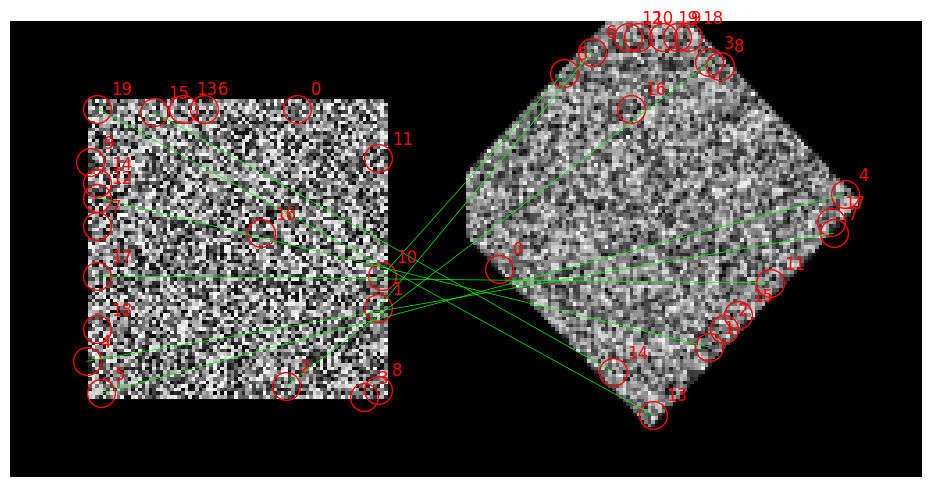

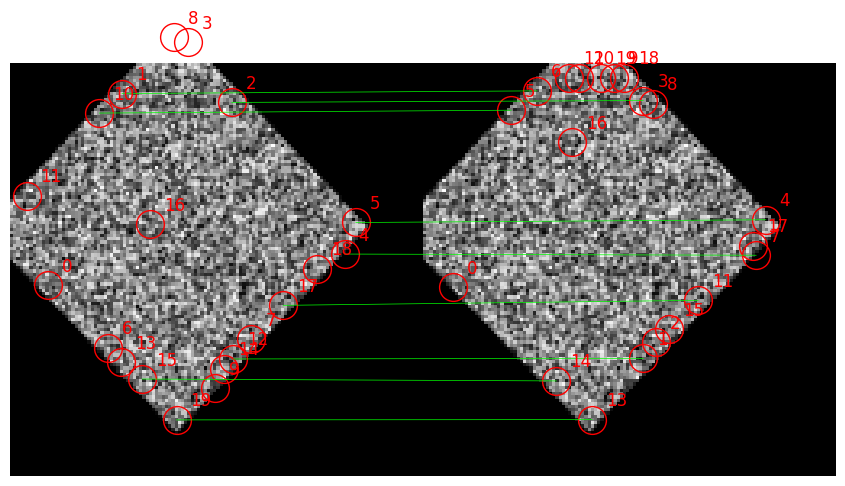

In [10]:
# Exemplo de uso
points1 = transform[0].cpu().numpy()
points2 = batch_points2[0].cpu().numpy()
threshold = 2.0
print("points1.shape:", points1.shape," points2.shape:", points2.shape)
matched = find_best_matching_indices_knn(points1, points2, threshold,k=3)
for (idx1,idx2) in matched:
    print(f"points1[{idx1}] -> points2[{idx2}]")

print(mask_trans.device,transform.device,mask.device)
plot_matches_keypoints(X1[0,0]*mask[0,0], batch_points[0].cpu(), out[0,0]*mask_trans[0,0], batch_points2[0].cpu(),matched)
plot_matches_keypoints(out[0,0]*mask_trans[0,0], transform[0].cpu(), out[0,0]*mask_trans[0,0], batch_points2[0].cpu(),matched)

### Treinamento

In [11]:
import torchvision
from torch import optim
from torch.optim.lr_scheduler import ExponentialLR
from torchvision.transforms import transforms, InterpolationMode

transform = transforms.Compose([
    transforms.Resize((args.img_size, args.img_size), interpolation=InterpolationMode.NEAREST),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])



trainset = torchvision.datasets.Flowers102(root='./data/datasets', split='train',
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=args.batch_size,
                                        shuffle=False, num_workers=2)

testset = torchvision.datasets.Flowers102(root='./data/datasets', split='test',
                                        download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=args.batch_size,
                                        shuffle=False, num_workers=2)


In [13]:
from tqdm import tqdm
import gc
from training import triplet_loss 
from training.tensor_augmetation import shifted_batch_tensor

transformations = K.AugmentationSequential(
    K.RandomAffine(degrees=180, translate=(0.1, 0.1), scale=(0.95, 1.05), shear=10,p=0.8),
    same_on_batch=True,
    data_keys = ['input','input','input', 'input','keypoints']  # Especificando as chaves de dados
)

def loss_point(lista_correspondencias,n_pontos=20):
    acertos = 0
    total = len(lista_correspondencias) * n_pontos
    margin = total*0.4
    
    for correspondencias in lista_correspondencias:
        acertos += len(correspondencias)

    erros = total - acertos
    print(f"acertos: {acertos} erros: {erros} total: {total}")
    loss = max(0, erros - acertos + margin)

    return torch.tensor(loss, requires_grad=True,dtype=torch.float).to(device)

#Create methods to train the model
def train_one_epoch(model,train_loader,optimizer,loss_map,loss_point,device='cpu',transformations=None):
    model.train()
    total_loss = 0.
    for batch_image, labels in tqdm(train_loader, desc="Train "):
        optimizer.zero_grad()   
        batch_image = batch_image.to(device)
        features_key,features_summary,features_ori,batch_points=predict_all_points(batch_image,mask)         
        batch_t,mask_t,features_summary_t,features_ori_t,batch_points_t = transformations(batch_image,mask,features_summary,features_ori,batch_points.to(device))# transformar orientacoes e pontos
        features_key_t2,features_summary_t2,features_ori_t2,batch_points_t2 =predict_all_points(batch_t,mask_t)# prever os pontos da imagem transformada
        lista_correspondencias = find_matching_in_batch(batch_points_t2.cpu(),batch_points_t.cpu(),threshold=2.0)
        
        batch_image_neg_trans, features_summary_neg, features_ori_neg = shifted_batch_tensor(batch_t, features_summary_t2,
                                                                    features_ori_t2)  # faz o shift com o comando roll(x,1,0)
        
        loss = loss_map(features_summary_t,features_summary_t2,features_summary_neg)+loss_map(features_ori_t,features_ori_t2,features_ori_neg)
        
        loss_m = loss_point(lista_correspondencias,n_pontos=POINTS_LIMIT)
        print("loss:",loss," loss_m:",loss_m)
        
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        print("adjusting learning rate")
        del batch_image,features_key,features_summary,features_ori,batch_points
        del batch_t,mask_t,features_summary_t,features_ori_t,batch_points_t
        gc.collect()
        torch.cuda.empty_cache()

        
    return total_loss/len(train_loader.dataset)

#Create methods to test the model
def test(model,test_loader,loss_fn,device='cpu'):
    model.eval()
    test_loss = 0.
    correct = 0.
    with torch.no_grad():
        for data in tqdm(test_loader, desc="Tests "):
            data = data.to(device)
            
            #refactor block
            data_pos = random_transform(data)
            output_pos = model(data,data_pos)
            #sift rool data
            data_neg =torch.roll(data_pos, 1, 0)
            output_neg = model(data,data_neg)

            test_loss +=  loss_fn(output_pos,output_neg).item()
    return test_loss/len(test_loader.dataset)



criterion_d = triplet_loss(is_ssim=args.is_loss_ssim, margim=args.margin_loss)

In [14]:
gc.collect()
torch.cuda.empty_cache()
i_epoch = 0
loss = 0
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0001)
scheduler = ExponentialLR(optimizer, gamma=0.75)

model=SingularPoints(args).to(device)
print("epoca {} loss {}".format(i_epoch, loss))
for epoch in range(i_epoch, args.epochs):
    running_loss = train_one_epoch(model, trainloader, optimizer=optimizer, loss_map=criterion_d,loss_point=loss_point,device=device,transformations=transformations)

Namespace(exported=False, num_channels=3, pyramid_levels=3, scale_pyramid=1.3, dim_first=3, dim_second=5, dim_third=8, group_size=36, epochs=70, border_size=22, box_size=31, nms_size=5, img_size=128, batch_size=8, path_data='./data', path_model='model.pt', is_loss_ssim=True, margin_loss=4.0, outlier_rejection=False, show_feature=False, border=21)
epoca 0 loss 0


Train :   0%|          | 0/128 [00:00<?, ?it/s]

acertos: 93 erros: 67 total: 160
loss: tensor(7.7389, device='cuda:0', grad_fn=<AddBackward0>)  loss_m: tensor(38., device='cuda:0', grad_fn=<ToCopyBackward0>)
adjusting learning rate


Train :   1%|          | 1/128 [01:00<2:08:10, 60.56s/it]

acertos: 98 erros: 62 total: 160
loss: tensor(7.7243, device='cuda:0', grad_fn=<AddBackward0>)  loss_m: tensor(28., device='cuda:0', grad_fn=<ToCopyBackward0>)
adjusting learning rate


Train :   2%|▏         | 2/128 [02:22<2:33:21, 73.03s/it]

In [ ]:
import torch
import numpy as np
# Exemplo de lote (batch) de pontos
batch_points1 = np.array([[[1, 2], [3, 4], [5, 6]], [[7, 8], [9, 10], [11, 12]]])
batch_points2 = np.array([[[2, 3], [4, 5], [6, 7]], [[8, 9], [10, 11], [12, 13]]])

# Limiar para determinar a distância máxima permitida
threshold = 2.0


lista_correspondencias = find_matching_in_batch(batch_points1, batch_points2, threshold)
# Exibir as correspondências
N_PONTOS =batch_points1.shape[1]
total = 0
for i, correspondencias in enumerate(lista_correspondencias):
    print(f"Correspondências do lote {i+1}:",correspondencias)
    total += len(correspondencias)
    for correspondencia in correspondencias:
        ponto1, ponto2 = correspondencia
        print(f"Ponto {ponto1} -> Ponto {ponto2}")
print(f"Total de correspondências: {total} {len(lista_correspondencias)*N_PONTOS}")

print(type(lista_correspondencias))

loss_point(lista_correspondencias)

Correspondências do lote 1: [(0, 0), (1, 0), (2, 1)]
Ponto 0 -> Ponto 0
Ponto 1 -> Ponto 0
Ponto 2 -> Ponto 1
Correspondências do lote 2: [(0, 0), (1, 0), (2, 1)]
Ponto 0 -> Ponto 0
Ponto 1 -> Ponto 0
Ponto 2 -> Ponto 1
Total de correspondências: 6 6
<class 'list'>
acertos: 6 erros: 0 total: 6


tensor(0., device='cuda:0', grad_fn=<ToCopyBackward0>)